In [3]:
# from glmhmm import *
import numpy as np
import sys
sys.path.append('/data/users/weixuan/work/model')
print(sys.path)
from fitting import *
from analysis import find_permutation, evaluate_classification, calculate_match_rate, matrix_comp

['/data/users/weixuan/work/model/glmhmm', '/home/wliu25/miniconda3/envs/glmhmm/lib/python38.zip', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/lib-dynload', '', '/home/wliu25/.local/lib/python3.8/site-packages', '/data/users/weixuan/work/model/ssm', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/setuptools/_vendor', '/data/users/weixuan/work/model']


/home/wliu25/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
N=500
dim_output=2
D = 7
K = 2


def metric_test(N, K, D, dim_output, num_models = 3):
    '''
    ws = np.zeros((num_init, num_states, n_features + 1, obs_dim))
    As = np.zeros((num_init, num_states, num_states))
    pi0s = np.zeros((num_init, num_states))
    
    '''

    # true model params
    A_true_all = np.zeros((num_models, K, K))
    w_true_all = np.zeros((num_models, K, D+1, dim_output))
    pi0_true_all = np.zeros((num_models, K))
    true_states_seq_all = np.zeros((num_models, N))


    # init pred model params
    A_init_all = np.zeros_like(A_true_all)
    w_init_all = np.zeros_like(w_true_all)
    pi0_init_all = np.zeros_like(pi0_true_all)
    init_states_seq_all = np.zeros_like(true_states_seq_all)
    # pred(post training) model params
    A_pred_all = np.zeros_like(A_true_all)
    w_pred_all = np.zeros_like(w_true_all)
    pi0_pred_all = np.zeros_like(pi0_true_all)
    pred_states_seq_all = np.zeros_like(true_states_seq_all)
    

    for i in range(num_models):
        # Set up true model and generate data
        X, Y, true_states_seq, A_true, w_true, pi0_true = gen_true_param(N, K, D, dim_output)
        A_true_all[i] = A_true
        w_true_all[i] = w_true
        pi0_true_all[i] = pi0_true
        true_states_seq_all[i] = true_states_seq.astype(int)

        # Fit a new model
        m = GLMHMM(N, K, D, dim_output, 1.0) #N, n_states, n_features, n_outputs
        A_init=m.transition_matrix
        w_init=m.w
        pi0_init  = m.pi0
        init_states_seq = m.mostprob_states(X, Y).astype(int)
        

        A_init_all[i] = A_init
        w_init_all[i] = w_init
        pi0_init_all[i] = pi0_init
        init_states_seq_all[i] = init_states_seq

        lls_pred,A_pred,w_pred,pi0_pred = m.fit(Y,X,A_init,w_init, pi0=pi0_init, fit_init_states=True)
        pred_states_seq = m.mostprob_states(X, Y)
        A_pred_all[i] = A_pred
        w_pred_all[i] = w_pred
        pi0_pred_all[i] = pi0_pred
        pred_states_seq_all[i] = pred_states_seq.astype(int)

    result = {
        'A_true_all': A_true_all,
        'w_true_all': w_true_all,
        'pi0_true_all': pi0_true_all,
        'true_states_seq_all': true_states_seq_all,
        'A_init_all': A_init_all,
        'w_init_all': w_init_all,
        'pi0_init_all': pi0_init_all,
        'init_states_seq_all': init_states_seq_all,
        'A_pred_all': A_pred_all,
        'w_pred_all': w_pred_all,
        'pi0_pred_all': pi0_pred_all,
        'pred_states_seq_all': pred_states_seq_all

    }
    # Analysis
    storage_all = np.zeros((num_models, num_models, 2, 9)) #2: init-0, pred-1 # (true, pred, true to init/pred, metric)
    
    for true_i in range(num_models):
        for pred_i in range(num_models):
            # extract the true params
            true_states_seq = true_states_seq_all[true_i]
            A_true = A_true_all[true_i]
            w_true = w_true_all[true_i]
            # extract the pred init params
            init_states_seq = init_states_seq_all[pred_i]
            A_init = A_init_all[pred_i]
            w_init = w_init_all[pred_i]
            # extract the pred params
            pred_states_seq = pred_states_seq_all[pred_i]
            A_pred = A_pred_all[pred_i]
            w_pred = w_pred_all[pred_i]

            # Permute the pred init states to align with true states
            init_states_seq = init_states_seq.astype(int)
            true_states_seq = true_states_seq.astype(int)
            pred_states_seq = pred_states_seq.astype(int)
            
            perm_init = find_permutation(init_states_seq, true_states_seq)
            init_states_perm = np.array([perm_init[init_states_seq[idx]] for idx in range(N)])
            A_perm_init = A_init[np.ix_(perm_init, perm_init)]
            w_perm_init = w_init[perm_init, :, :]
            # Permute the pred states to align with true states
            perm = find_permutation(pred_states_seq, true_states_seq)
            pred_states_perm = np.array([perm[pred_states_seq[idx]] for idx in range(N)])
            A_perm = A_pred[np.ix_(perm, perm)]
            w_perm = w_pred[perm, :, :]

            # Metric
            # Matrix comparison
            A_true2pred_element = matrix_comp(A_true, A_perm, metric="element") #0
            A_true2pred_vector = matrix_comp(A_true, A_perm, metric="vector") #1
            A_true2init_element = matrix_comp(A_true, A_init, metric="element")
            A_true2init_vector = matrix_comp(A_true, A_init, metric="vector")

            w_true2pred_element = matrix_comp(w_true, w_perm, metric="element") #2
            w_true2pred_vector = matrix_comp(w_true, w_perm, metric="vector") #3
            w_true2init_element = matrix_comp(w_true, w_init, metric="element")
            w_true2init_vector = matrix_comp(w_true, w_init, metric="vector")
            # State seq evaluation
            res_map_true2pred = evaluate_classification(pred_states_perm, true_states_seq)
            accuracy_true2pred = res_map_true2pred['accuracy'] #4
            precision_true2pred = res_map_true2pred['precision'] #5
            recall_true2pred = res_map_true2pred['recall'] #6
            f1_true2pred = res_map_true2pred['f1_score'] #7

            res_map_true2init = evaluate_classification(init_states_perm, true_states_seq)
            accuracy_true2init = res_map_true2init['accuracy']
            precision_true2init = res_map_true2init['precision']
            recall_true2init = res_map_true2init['recall']
            f1_true2init = res_map_true2init['f1_score']

            # matching rate of state seq
            mat_rate_true2pred = calculate_match_rate(pred_states_perm, true_states_seq) #8
            mat_rate_true2init = calculate_match_rate(init_states_perm, true_states_seq)

            # Storage
            storage_all[true_i, pred_i, 0] = np.array([A_true2init_element, A_true2init_vector, w_true2init_element, w_true2init_vector, \
                accuracy_true2init, precision_true2init, recall_true2init, f1_true2init, mat_rate_true2init])

            storage_all[true_i, pred_i, 1] = np.array([A_true2pred_element, A_true2pred_vector, w_true2pred_element, w_true2pred_vector, \
                accuracy_true2pred, precision_true2pred, recall_true2pred, f1_true2pred, mat_rate_true2pred])

    result['storage_all'] = storage_all
    return result
    

In [5]:
result = metric_test(N, K, D, dim_output, num_models = 3)

Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Iter10
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9


/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
storage_all

NameError: name 'storage_all' is not defined

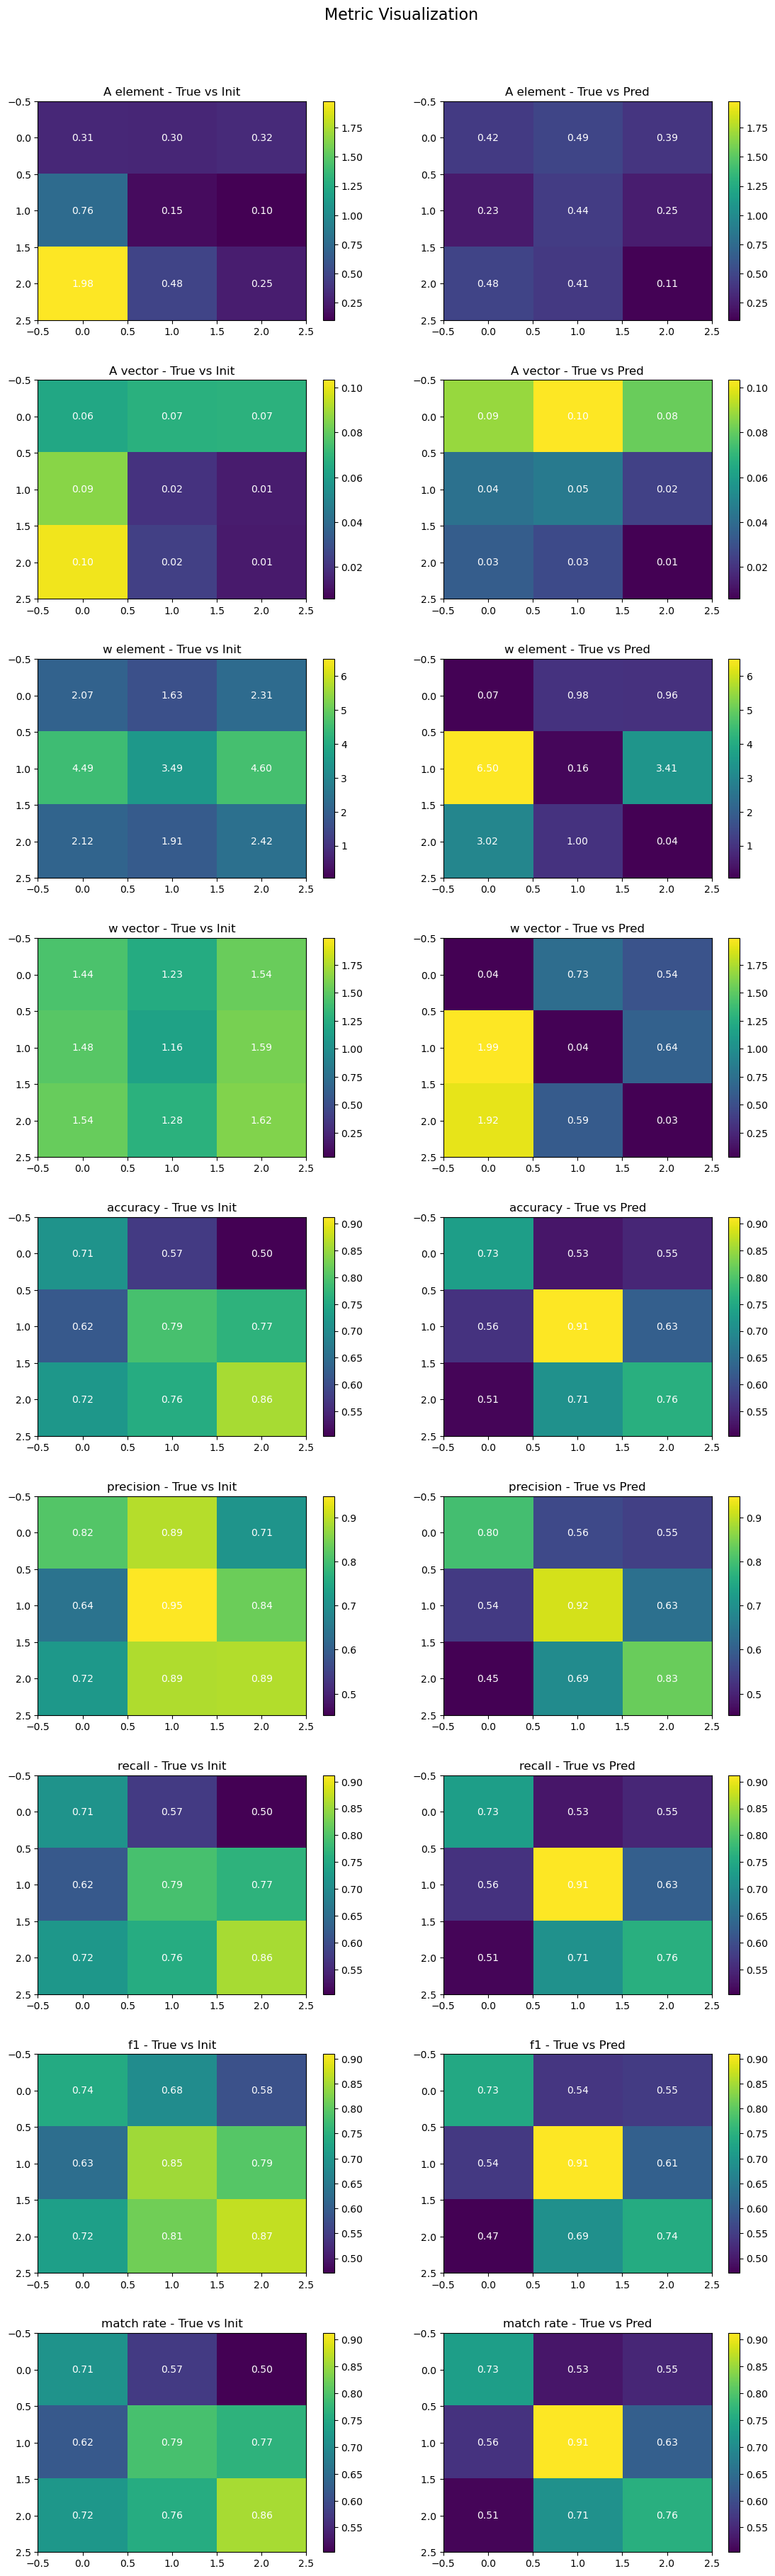

In [10]:

storage_all = result['storage_all'] #(true, pred, true to init/pred, metric)
metrics = ["A element", "A vector", "w element", "w vector", "accuracy", "precision", "recall", "f1", "match rate"]

fig, axes = plt.subplots(9, 2, figsize=(12, 36))
fig.tight_layout(pad=4.0)

# Iterate through metrics and subplots
for idx, metric in enumerate(metrics):
    # Extract data for the current metric
    true2init = storage_all[:, :, 0, idx]
    true2pred = storage_all[:, :, 1, idx]

    # Compute vmin and vmax for the current row (shared between true2init and true2pred)
    vmin = min(true2init.min(), true2pred.min())
    vmax = max(true2init.max(), true2pred.max())

    # Plot true-to-init
    ax_init = axes[idx, 0]
    c1 = ax_init.imshow(true2init, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
    ax_init.set_title(f"{metric} - True vs Init")
    fig.colorbar(c1, ax=ax_init)
    # Add text annotations for each value
    for i in range(true2init.shape[0]):
        for j in range(true2init.shape[1]):
            ax_init.text(j, i, f"{true2init[i, j]:.2f}", ha='center', va='center', color='white')

    # Plot true-to-pred
    ax_pred = axes[idx, 1]
    c2 = ax_pred.imshow(true2pred, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
    ax_pred.set_title(f"{metric} - True vs Pred")
    fig.colorbar(c2, ax=ax_pred)
    # Add text annotations for each value
    for i in range(true2pred.shape[0]):
        for j in range(true2pred.shape[1]):
            ax_pred.text(j, i, f"{true2pred[i, j]:.2f}", ha='center', va='center', color='white')

# Add overall figure title
fig.suptitle("Metric Visualization", fontsize=16, y=1.02)

# Display the plots
plt.show()


In [3]:
X1, Y1, true_states_seq1, A_true1, w_true1, pi0_true1 = gen_true_param(N, K, D, dim_output)
X2, Y2, true_states_seq2, A_true2, w_true2, pi0_true2 = gen_true_param(N, K, D, dim_output)

In [4]:
m1 = GLMHMM(N, K, D, dim_output, 1.0) #N, n_states, n_features, n_outputs
A_init1=m1.transition_matrix
w_init1=m1.w
lls_pred1,A_pred1,w_pred1,pi0_pred1 = m1.fit(Y1,X1,A_init1,w_init1, fit_init_states=True)

Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9


In [12]:
pred_states_seq1 = m1.mostprob_states(X1, Y1)

/data/users/weixuan/work/model/glmhmm/glmhmm.py:462: RuntimeWarning: divide by zero encountered in log
  np.log(self._compute_likelihood(X_augmented[t], Y[t])[j]))
/data/users/weixuan/work/model/glmhmm/glmhmm.py:464: RuntimeWarning: divide by zero encountered in log
  np.log(self._compute_likelihood(X_augmented[t], Y[t])[j]))


In [13]:
pred_states_seq1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
m2 = GLMHMM(N, K, D, dim_output, 1.0) #N, n_states, n_features, n_outputs
A_init2=m2.transition_matrix
w_init2=m2.w
lls_pred2,A_pred2,w_pred2,pi0_pred2 = m2.fit(Y2,X2,A_init2,w_init2, fit_init_states=True)

Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9


In [10]:
pred_states_seq2 = m2.mostprob_states(X2, Y2)

In [11]:
pred_states_seq2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,

In [41]:
# Apply those metrics

# Permute states 
perm1 = find_permutation(pred_states_seq1, true_states_seq1)
pred_states_perm1 = np.array([perm1[pred_states_seq1[idx]] for idx in range(N)])
A_perm1 = A_pred1[np.ix_(perm1, perm1)]
w_perm1 = w_pred1[perm1, :, :]

In [38]:
w_true1

array([[[-0.19013904, -0.93677205],
        [-0.74692553, -0.593289  ],
        [-0.38786624, -0.16372864],
        [-0.53119145, -0.16631012],
        [-0.00254784, -0.98334534],
        [-0.65384389, -0.92761853],
        [-0.11354219, -0.67730854],
        [ 0.        ,  0.        ]],

       [[ 0.52831886,  0.92349298],
        [ 0.20323374,  0.7210474 ],
        [ 0.38743098,  0.84596426],
        [ 0.31790035,  0.22014139],
        [ 0.90133491,  0.65710237],
        [ 0.7213772 ,  0.04972955],
        [ 0.88076277,  0.67962071],
        [ 0.        ,  0.        ]]])

In [42]:
A_comp_element1 = matrix_comp(A_true1, A_perm1, metric="element")
A_comp_vector1 = matrix_comp(A_true1, A_perm1, metric="vector")
w_comp_element1 = matrix_comp(w_true1, w_perm1, metric="element")
w_comp_vector1 = matrix_comp(w_true1, w_perm1, metric="vector")


In [44]:
A_comp_element, A_comp_vector, w_comp_element1, w_comp_vector1

(0.6163059150382226, 0.4979360340877688, inf, 1.2950123981403079)

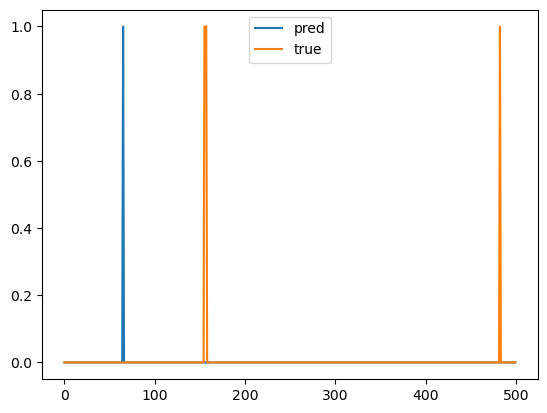

In [29]:
plt.plot(pred_states_perm1, label='pred')
plt.plot(true_states_seq1, label = 'true')
plt.legend()

In [27]:
perm2 = find_permutation(pred_states_seq2, true_states_seq2)
pred_states_perm2 = np.array([perm2[pred_states_seq2[idx]] for idx in range(N)])

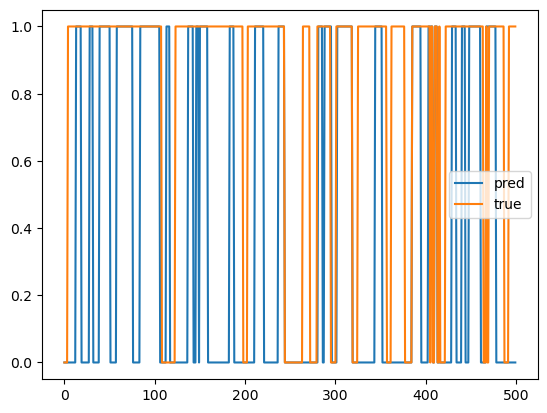

In [28]:
plt.plot(pred_states_perm2, label='pred')
plt.plot(true_states_seq2, label = 'true')
plt.legend()

In [ ]:
W_permuted = W[perm, :, :]